# Intuit Quickbooks Upgrade


## Step 1: Data Preprocessing 

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [3]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_parquet("data/intuit75k.parquet")
intuit75k["res1_yes"] = rsm.ifelse(intuit75k.res1 == "Yes", 1, 0)

rsm.describe(intuit75k)

No description attribute available


,id,zip_bins,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,training,res1_yes
count,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.00000,75000.000000,75000.000000,75000.000000,75000.000000
mean,37500.500000,10.498333,0.245080,2.076280,93.087133,15.838427,15.657173,0.21400,0.028693,0.208387,0.700000,0.048013
std,21650.779432,5.765751,0.430137,1.241355,81.205900,9.539057,10.026312,0.41013,0.166944,0.406157,0.458261,0.213796
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,18750.750000,5.000000,0.000000,1.000000,37.000000,8.000000,7.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,37500.500000,10.000000,0.000000,2.000000,71.000000,15.000000,14.000000,0.00000,0.000000,0.000000,1.000000,0.000000
75%,56250.250000,15.000000,0.000000,3.000000,124.500000,24.000000,24.000000,0.00000,0.000000,0.000000,1.000000,0.000000
max,75000.000000,20.000000,1.000000,5.000000,1149.000000,36.000000,36.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [4]:
intuit75k.head()


,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [5]:
# run python code from another notebook
%run ./sub-notebooks/question1.ipynb

      index     OR     OR%   2.5%  97.5% p.values     
1   numords  1.352   35.2%  1.313  1.392   < .001  ***
2  version1  2.113  111.3%  1.911  2.335   < .001  ***
3  upgraded  2.628  162.8%  2.388  2.894   < .001  ***


/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [6]:
# Investigating the data types
intuit75k.dtypes

id               int32
zip5            object
zip_bins         int32
sex           category
bizflag          int32
numords          int32
dollars        float64
last             int32
sincepurch       int32
version1         int32
owntaxprod       int32
upgraded         int32
res1          category
training         int32
res1_yes         int64
dtype: object

In [7]:
# Convert zip_bins to a categorical variable
intuit75k['zip_bins'] = intuit75k['zip_bins'].astype('category')

We converted zip_bins to a categorical variable, since keeping it as an integer would impose a linear relationship between the zip code and the target variable.

In [8]:
# Confirm the change
intuit75k.dtypes

id               int32
zip5            object
zip_bins      category
sex           category
bizflag          int32
numords          int32
dollars        float64
last             int32
sincepurch       int32
version1         int32
owntaxprod       int32
upgraded         int32
res1          category
training         int32
res1_yes         int64
dtype: object

In [9]:
# Investigating the training data
intuit75k[intuit75k.training == 1].describe()

,id,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,training,res1_yes
count,52500.000000,52500.00000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.0,52500.000000
mean,37500.368590,0.24419,2.070762,92.681600,15.856457,15.616686,0.213143,0.028629,0.207181,1.0,0.047581
std,21646.602035,0.42961,1.239721,80.896686,9.546888,10.023926,0.409532,0.166762,0.405290,0.0,0.212880
min,1.000000,0.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,18774.750000,0.00000,1.000000,36.500000,8.000000,7.000000,0.000000,0.000000,0.000000,1.0,0.000000
50%,37532.500000,0.00000,2.000000,70.500000,15.000000,14.000000,0.000000,0.000000,0.000000,1.0,0.000000
75%,56245.250000,0.00000,3.000000,124.000000,24.000000,24.000000,0.000000,0.000000,0.000000,1.0,0.000000
max,74999.000000,1.00000,5.000000,1149.000000,36.000000,36.000000,1.000000,1.000000,1.000000,1.0,1.000000


Large amount of variance between means and standard deviations of the different features indicates that the variables are on different scales. We will need to measure the impact of the variables on a std scale.

In [10]:
# Investigating the positive responses
intuit75k[intuit75k.res1_yes == 1].describe()

,id,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,training,res1_yes
count,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.0
mean,37578.261594,0.246598,2.593169,117.630519,12.032769,19.179672,0.293807,0.050264,0.329075,0.693696,1.0
std,21817.155270,0.431091,1.429354,102.827317,8.937035,9.936447,0.455568,0.218519,0.469943,0.461021,0.0
min,12.000000,0.000000,1.000000,3.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,18948.000000,0.000000,1.000000,47.000000,4.000000,11.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,37514.000000,0.000000,2.000000,89.500000,11.000000,20.000000,0.000000,0.000000,0.000000,1.000000,1.0
75%,56491.000000,0.000000,4.000000,160.500000,18.000000,27.000000,1.000000,0.000000,1.000000,1.000000,1.0
max,74996.000000,1.000000,5.000000,1149.000000,36.000000,36.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [12]:
# Investigating the number of positive and negative responses in the training and test data
count = intuit75k.groupby(["training", "res1_yes"]).agg(count=('training', 'count')).reset_index()

count

,training,res1_yes,count
0,0,0,21397
1,0,1,1103
2,1,0,50002
3,1,1,2498


In [13]:
# Count NA values
intuit75k.isna().sum()

id            0
zip5          0
zip_bins      0
sex           0
bizflag       0
numords       0
dollars       0
last          0
sincepurch    0
version1      0
owntaxprod    0
upgraded      0
res1          0
training      0
res1_yes      0
dtype: int64

There are no missing values in the dataset, so we don't need to worry about inputting missing values.

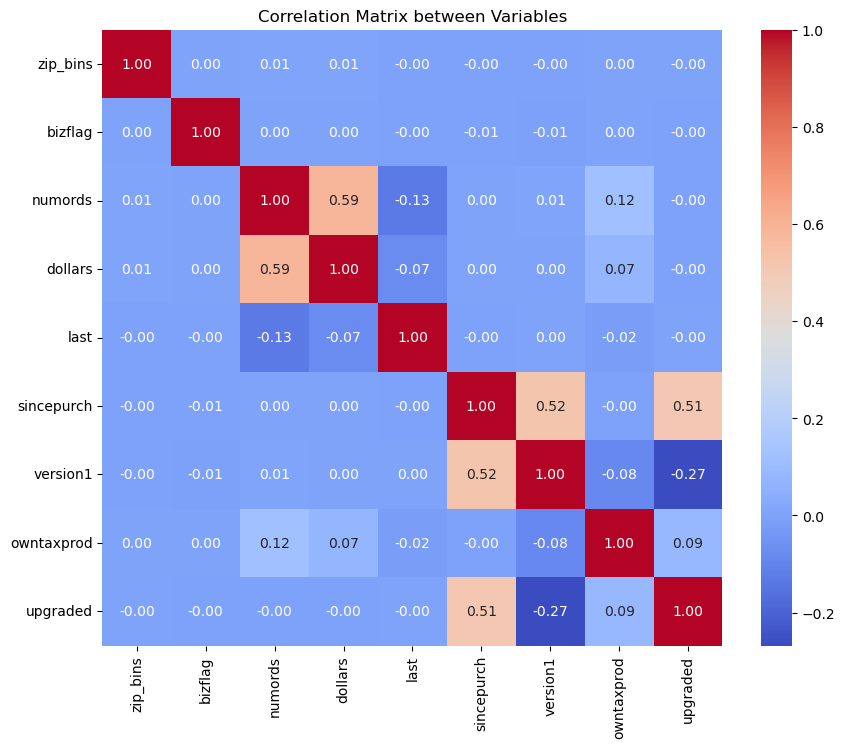

In [98]:
import seaborn as sns

# Generate a DataFrame with random data
np.random.seed(0)  # For reproducible output

# Calculate the correlation matrix
corr_matrix = intuit75k[["zip_bins", "bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"]].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix between Variables')
plt.show()


## Step 2: Logistic Regression

In [14]:
# Logistic regression (base model) - all predictors
lr = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1",
    lev="Yes",
    evar=["zip_bins", "sex", "bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"],
)

lr.summary(vif=True)

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, sex, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded
Null hyp.: There is no effect of x on res1
Alt. hyp.: There is an effect of x on res1

                 OR     OR%  coefficient  std.error  z.value p.value     
Intercept     0.245  -75.5%        -1.41      0.080  -17.673  < .001  ***
zip_bins[2]   0.152  -84.8%        -1.89      0.094  -20.178  < .001  ***
zip_bins[3]   0.119  -88.1%        -2.12      0.102  -20.828  < .001  ***
zip_bins[4]   0.138  -86.2%        -1.98      0.095  -20.872  < .001  ***
zip_bins[5]   0.114  -88.6%        -2.17      0.103  -21.079  < .001  ***
zip_bins[6]   0.121  -87.9%        -2.11      0.099  -21.285  < .001  ***
zip_bins[7]   0.125  -87.5%        -2.08      0.099  -21.038  < .001  ***
zip_bins[8]   0.123  -87.7%        -2.10      0.099  -21.103  < .001  ***
zip_bins[9]   0.124  -

**Interpretation of Model:**

- **Model Significance:** The p-value of the Chi-squared test is <0.001, meaning we can reject the null hypothesis that all the coefficients for the explanatory variables are equal to zero and all Odds-ratios are 1. Therefore, we can conclude that the overall model is statistically significant. 

- **Pseudo R-Squared:** The pseudo R-squared is 0.121, positioning the model's explanatory power on the lower end of the continuum (0 to 1). This indicates the model has only moderate predictive ability, but does not mean that the model is not useful, rather that there is potential for it to be improved with additional data. We need to consider other metrics to evaluate the model's performance.

- **AUC:** The AUC is 0.755, meaning that the model has a 75.5% probability of ranking a randomly chosen positive occurrence higher than a randomly chosen negative occurrence in terms of predicted probabilities. This metric indicates that the model has a good ability to distinguish between positive and negative classes.

- **Nr. of Observations:** The model is based on 53,603 observations, indicating that we correctly included the 52,500 observations in the training set and the 1,103 positive observations from the test set.

- **Odds Ratios:** The odds ratios for the explanatory variables indicate the change in the odds of the target variable for a one-unit change in the explanatory variable, holding all other variables constant. We cannot use the coefficients to interpret the impact of the explanatory variables on the target variable as the variables are on different scales. We need to measure the impact of the variables on a standardized scale, which we will do in the next step.

- **VIF:** The VIF values for the explanatory variables are all below 5, indicating that multicollinearity is not a concern in the model.

- **Variable Significance:** There are several variables (sex, bizflag, and sincepurch) with p-values >0.05, indicating that they are not statistically significant at the 0.05 level. We will test the model again without these variables and perform a chi-squared test to see if the model is significantly different from the base model.

In [20]:
# Logistic regression (base model) - test for insignificant predictors
lr.summary(main=False, fit=False, test=["sex", "bizflag", "sincepurch"])


Model 1: res1 ~ zip_bins + numords + dollars + last + version1 + owntaxprod + upgraded
Model 2: res1 ~ zip_bins + sex + bizflag + numords + dollars + last + sincepurch + version1 + owntaxprod + upgraded
Pseudo R-squared, Model 1 vs 2: 0.121 vs 0.121
Chi-squared: 0.297 df (4), p.value 0.99


After running a logistic regression of the model with and without the sex, bizflag, and sincepurch variables, we can see that the Pseudo R-squared for both models is 0.121: This value indicates that, despite the additional variables in Model 2, both models have the same predictive power. 

The chi-squared test compares the fit of the two models. The p-value of 0.99 is much higher than an acceptable alpha level of 0.05. The high p-value in the chi-squared test indicates that the addition of sex, bizflag, and sincepurch in Model 2 does not significantly improve the model's predictive ability compared to Model 1. Essentially, the complexity added by these variables does not translate into a better fit.

Before removing the variables, we will re-run the model without the variables to see if the coefficients of the odds ratios of the other variables change to test for potential multicollinearity.

In [24]:
# Logistic regression (model 2) - removing insignificant predictors (sex, bizflag, sincepurch)
lrM2 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1",
    lev="Yes",
    evar=["zip_bins", "numords", "dollars", "last", "version1", "owntaxprod", "upgraded"],
)

lrM2.summary(main=False)


Pseudo R-squared (McFadden): 0.121
Pseudo R-squared (McFadden adjusted): 0.119
Area under the RO Curve (AUC): 0.755
Log-likelihood: -11601.21, AIC: 23254.421, BIC: 23485.544
Chi-squared: 3200.294, df(25), p.value < 0.001 
Nr obs: 53,603


In [25]:
# Coefficients of the base model
lr.coef

,index,OR,OR%,coefficient,std.error,z.value,p.value,
0,Intercept,0.244917,-75.508338,-1.406837,0.079602,-17.673384,6.724000e-70,***
1,zip_bins[T.2],0.151553,-84.844678,-1.886818,0.093510,-20.177812,1.533871e-90,***
2,zip_bins[T.3],0.119461,-88.053868,-2.124763,0.102015,-20.828015,2.412521e-96,***
3,zip_bins[T.4],0.137824,-86.217612,-1.981779,0.094951,-20.871584,9.706332e-97,***
4,zip_bins[T.5],0.113739,-88.626124,-2.173851,0.103130,-21.078694,1.247806e-98,***
5,zip_bins[T.6],0.120993,-87.900661,-2.112019,0.099227,-21.284750,1.571816e-100,***
6,zip_bins[T.7],0.125342,-87.465800,-2.076709,0.098713,-21.037878,2.953024e-98,***
7,zip_bins[T.8],0.122793,-87.720702,-2.097255,0.099380,-21.103337,7.411710e-99,***
8,zip_bins[T.9],0.123856,-87.614389,-2.088635,0.099461,-20.999590,6.615427e-98,***
9,zip_bins[T.10],0.129579,-87.042069,-2.043462,0.097829,-20.888066,6.874732e-97,***


In [26]:
# Coefficients of model 2
lrM2.coef

,index,OR,OR%,coefficient,std.error,z.value,p.value,
0,Intercept,0.249987,-75.001300,-1.386346,0.064819,-21.388091,1.724733e-101,***
1,zip_bins[T.2],0.151578,-84.842163,-1.886652,0.093504,-20.177188,1.553350e-90,***
2,zip_bins[T.3],0.119440,-88.055988,-2.124940,0.102006,-20.831496,2.243416e-96,***
3,zip_bins[T.4],0.137844,-86.215562,-1.981630,0.094944,-20.871615,9.700041e-97,***
4,zip_bins[T.5],0.113727,-88.627310,-2.173955,0.103125,-21.080743,1.194940e-98,***
5,zip_bins[T.6],0.121013,-87.898718,-2.111859,0.099224,-21.283664,1.608651e-100,***
6,zip_bins[T.7],0.125332,-87.466823,-2.076791,0.098702,-21.040956,2.767425e-98,***
7,zip_bins[T.8],0.122756,-87.724396,-2.097556,0.099373,-21.107905,6.729012e-99,***
8,zip_bins[T.9],0.123854,-87.614642,-2.088655,0.099455,-21.000974,6.425416e-98,***
9,zip_bins[T.10],0.129544,-87.045630,-2.043737,0.097824,-20.891970,6.335116e-97,***


After re-running the model without the sex, bizflag, and sincepurch variables, we can see that the odds ratios of the other variables do not change significantly. This suggests that multicollinearity (omitted variable bias) is not a problem in the model.

Finally, before removing the variables, we will test for interactions between the variables to see if the variables are related to each other in a non-linear way.

In [27]:
# Run lr base model with res1_yes as the dependent variable instead of res1 (response variable must be numeric for the test interaction function)
lr_res_yes = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins", "sex", "bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"],
)

In [44]:
import itertools
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

def test_interactions(data, predictors):
    """
    Automatically generates and tests interaction terms between all given predictor variables.
    
    :param data: A pandas DataFrame containing the dataset.
    :param predictors: A list of column names (strings) to be used as predictors.
    """
    # Generate all pairwise combinations of predictors for interaction terms
    interaction_pairs = list(itertools.combinations(predictors, 2))
    
    for pair in interaction_pairs:
        # Create an interaction term as a string, e.g., "zip_bins:sex"
        interaction_term = f"{pair[0]}:{pair[1]}"
        
        # Construct the formula for the logistic regression model
        formula = f"res1_yes ~ {' + '.join(predictors)} + {interaction_term}"
        
        # Fit the logistic regression model with the interaction term
        model = smf.logit(formula, data=data).fit()
        
        # Print the results
        print(f"Interaction between {pair[0]} and {pair[1]}:")
        print(model.summary())
        print("\n" + "-"*50 + "\n")


In [45]:
predictors = ["zip_bins", "sex", "bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"]

#test_interactions(intuit75k, predictors)

Optimization terminated successfully.
         Current function value: 0.170255
         Iterations 8
Interaction between zip_bins and sex:
                           Logit Regression Results                           
Dep. Variable:               res1_yes   No. Observations:                75000
Model:                          Logit   Df Residuals:                    74932
Method:                           MLE   Df Model:                           67
Date:                Wed, 07 Feb 2024   Pseudo R-squ.:                  0.1161
Time:                        13:12:05   Log-Likelihood:                -12769.
converged:                       True   LL-Null:                       -14447.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       

LinAlgError: Singular matrix

Attempted to test for interactions between all variables, but the model did not converge. We will test for interactions between the variables in smaller groups to see if we can find any significant interactions. 

First, we will test for interactions between zip_bins and all other variables since zip_bins has the greatest number of categories and adds complexity to the model.

In [20]:
import itertools
import pandas as pd
import statsmodels.formula.api as smf

def test_interactions_zip_bins(data, predictors):
    """
    Automatically generates and tests interaction terms between 'zip_bins' and all other given predictor variables.
    
    :param data: A pandas DataFrame containing the dataset.
    :param predictors: A list of column names (strings) to be used as predictors.
    """
    # Ensure 'zip_bins' is removed from the predictors to avoid self-interaction
    if 'zip_bins' in predictors:
        predictors.remove('zip_bins')
    
    # Create interaction terms only between 'zip_bins' and each of the other predictors
    interaction_pairs = [('zip_bins', pred) for pred in predictors]
    
    for pair in interaction_pairs:
        # Create an interaction term as a string, e.g., "zip_bins:sex"
        interaction_term = f"{pair[0]}:{pair[1]}"
        
        # Construct the formula for the logistic regression model
        formula = f"res1_yes ~ {' + '.join(['zip_bins'] + predictors)} + {interaction_term}"
        
        # Fit the logistic regression model with the interaction term
        model = smf.logit(formula, data=data).fit()
        
        # Print the summary of the model or perform your custom analysis/plotting
        print(f"Interaction between {pair[0]} and {pair[1]}:")
        print(model.summary())
        print("\n" + "-"*50 + "\n")


In [21]:
predictors = ["zip_bins", "sex", "bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"]

#test_interactions_zip_bins(intuit75k, predictors)

Optimization terminated successfully.
         Current function value: 0.170255
         Iterations 8
Interaction between zip_bins and sex:
                           Logit Regression Results                           
Dep. Variable:               res1_yes   No. Observations:                75000
Model:                          Logit   Df Residuals:                    74932
Method:                           MLE   Df Model:                           67
Date:                Wed, 07 Feb 2024   Pseudo R-squ.:                  0.1161
Time:                        09:09:51   Log-Likelihood:                -12769.
converged:                       True   LL-Null:                       -14447.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       

The results of the test for interactions between zip_bins suggests that there are significant interactions between zip_bins and sex, numords, dollars, last, sincepurch, version1, and upgraded.

The significant interaction terms highlight that the influence of geographical location (as categorized into zip code bins) on the likelihood of responding to the upsell campaign is moderated by factors such as the number of orders, the time since the last order, the time since the original QuickBooks purchase, the QuickBooks version owned, and whether the customer previously purchased tax software or upgraded their QuickBooks software. These interactions suggest complex relationships that warrant further investigation to understand the underlying dynamics and to tailor marketing strategies accordingly.

We will run the model again with the significant interaction with zip_bins and then test for interactions between other variables.

In [29]:
# Logistic regression (model 3) - adding significant interaction terms
lrM3 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins", "sex", "bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"],
    ivar = ["zip_bins:sex", "zip_bins:numords", "zip_bins:dollars", "zip_bins:last", "zip_bins:sincepurch", "zip_bins:version1", "zip_bins:upgraded"],
)

lrM3.summary()

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, sex, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                              OR     OR%  coefficient  std.error  z.value p.value     
Intercept                  0.370  -63.0%        -0.99      0.157   -6.346  < .001  ***
zip_bins[2]                0.075  -92.5%        -2.59      0.377   -6.852  < .001  ***
zip_bins[3]                0.070  -93.0%        -2.66      0.395   -6.724  < .001  ***
zip_bins[4]                0.078  -92.2%        -2.54      0.358   -7.108  < .001  ***
zip_bins[5]                0.084  -91.6%        -2.48      0.382   -6.492  < .001  ***
zip_bins[6]                0.037  -96.3%        -3.28      0.409   -8.031  < .001  ***
zip_bins[7]                0.045  -95.5%        -3.09      0.403   -7

After running the model with the significant interaction between zip_bins and the other variables, we can see that the model is still significant, with a p-value of <0.001 and the Pseudo R-squared value has increased slightly from to base model to 0.131. However, the model is significantly more complex with the addition of the interaction terms, and many of the interaction terms are not significant at the 0.05 level.

We will run a chi-squared test to see if the model with all the interaction terms is significantly different from the model after removing the non-significant interaction terms.

Additionally, after adding the interaction terms, the dollars variable and the since purch variable are no longer significant at the 0.05 level, nor are any of the interaction terms with them. We will also test the model without these variables.

In [30]:
lrM3.summary(main=False, fit=False, test=["dollars", "zip_bins:dollars", "sincepurch", "zip_bins:sincepurch"])


Model 1: res1_yes ~ zip_bins + sex + bizflag + numords + last + version1 + owntaxprod + upgraded + zip_bins:last + zip_bins:numords + zip_bins:sex + zip_bins:upgraded + zip_bins:version1
Model 2: res1_yes ~ zip_bins + sex + bizflag + numords + dollars + last + sincepurch + version1 + owntaxprod + upgraded + zip_bins:sex + zip_bins:numords + zip_bins:dollars + zip_bins:last + zip_bins:sincepurch + zip_bins:version1 + zip_bins:upgraded
Pseudo R-squared, Model 1 vs 2: 0.129 vs 0.131
Chi-squared: 44.673 df (40), p.value 0.282


The chi-squared test comparing the model with all the interaction terms and the model without the non-significant interaction terms has a p-value of 0.282, which is greater than the alpha level of 0.05. This indicates that the base model including all the interaction terms is not significantly different from the model without the dollars and sincepurch variables or their intraction terms, and we can likely remove the non-significant interaction terms.

But first, we will run the model without the dollars and sincepurch variables to see if the coefficients/odds ratios of the other variables change to test for potential multicollinearity.

In [32]:
lrM4 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins", "sex", "bizflag", "numords", "last", "version1", "owntaxprod", "upgraded"],
    ivar = ["zip_bins:sex", "zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded"],
)

lrM4.coef

,index,OR,OR%,coefficient,std.error,z.value,p.value,
0,Intercept,0.386625,-61.337473,-0.950299,0.140766,-6.750924,1.469067e-11,***
1,zip_bins[T.2],0.063971,-93.602853,-2.749318,0.347252,-7.917361,2.426047e-15,***
2,zip_bins[T.3],0.065754,-93.424618,-2.721838,0.366595,-7.424649,1.130790e-13,***
3,zip_bins[T.4],0.075329,-92.467142,-2.585896,0.327878,-7.886752,3.101533e-15,***
4,zip_bins[T.5],0.078466,-92.153401,-2.545090,0.352903,-7.211875,5.518680e-13,***
...,...,...,...,...,...,...,...,...
137,zip_bins[T.16]:upgraded,2.145624,114.562378,0.763430,0.243009,3.141573,1.680430e-03,**
138,zip_bins[T.17]:upgraded,1.384633,38.463331,0.325435,0.239014,1.361577,1.733314e-01,
139,zip_bins[T.18]:upgraded,1.795550,79.554954,0.585311,0.213535,2.741054,6.124236e-03,**
140,zip_bins[T.19]:upgraded,2.935585,193.558474,1.076907,0.227014,4.743795,2.097515e-06,***


None of the odds ratios of the other variables change significantly after removing the dollars and sincepurch variables, which suggests that multicollinearity is not a problem in the model.

However, the sex variable is still not significant at the 0.05 level and only a few of the interaction terms are significant at the 0.05 level. We will test the model without this variable.

In [33]:
lrM4.summary(main=False, fit=False, test=["sex"])


Model 1: res1_yes ~ zip_bins + bizflag + numords + last + version1 + owntaxprod + upgraded + zip_bins:last + zip_bins:numords + zip_bins:upgraded + zip_bins:version1
Model 2: res1_yes ~ zip_bins + sex + bizflag + numords + last + version1 + owntaxprod + upgraded + zip_bins:sex + zip_bins:numords + zip_bins:last + zip_bins:version1 + zip_bins:upgraded
Pseudo R-squared, Model 1 vs 2: 0.127 vs 0.129
Chi-squared: 38.136 df (40), p.value 0.554


The chi-squared test comparing the model with sex and its interactions and the model without sex and interaction terms has a p-value of 0.554, which is greater than the alpha level of 0.05. This indicates that the base model is not significantly different from the model without the sex variable and its interaction terms, and we can likely remove the non-significant interaction terms.

But first, we will run the model without the sex variable if the coefficients/odds ratios of the other variables change to test for potential multicollinearity.

In [35]:
lrM5 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins", "bizflag", "numords", "last", "version1", "owntaxprod", "upgraded"],
    ivar = ["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded"],
)

lrM5.coef

,index,OR,OR%,coefficient,std.error,z.value,p.value,
0,Intercept,0.347713,-65.228744,-1.056379,0.118662,-8.902397,5.465357e-19,***
1,zip_bins[T.2],0.098768,-90.123168,-2.314978,0.270479,-8.558801,1.140476e-17,***
2,zip_bins[T.3],0.101375,-89.862495,-2.288928,0.298817,-7.659961,1.859889e-14,***
3,zip_bins[T.4],0.077486,-92.251366,-2.557654,0.278377,-9.187748,4.011506e-20,***
4,zip_bins[T.5],0.085619,-91.438145,-2.457853,0.294993,-8.331893,7.955980e-17,***
...,...,...,...,...,...,...,...,...
97,zip_bins[T.16]:upgraded,2.165438,116.543797,0.772623,0.242866,3.181270,1.466309e-03,**
98,zip_bins[T.17]:upgraded,1.398790,39.878993,0.335608,0.238830,1.405216,1.599569e-01,
99,zip_bins[T.18]:upgraded,1.790727,79.072718,0.582622,0.213266,2.731906,6.296914e-03,**
100,zip_bins[T.19]:upgraded,2.969450,196.944963,1.088377,0.226807,4.798697,1.597012e-06,***


None of the odds ratios of the other variables change significantly after removing the sex variables, which suggests that multicollinearity is not a problem in the model.

However, the bizflag variable is still not significant at the 0.05 level and only a few of the interaction terms are significant at the 0.05 level. We will test the model without this variable.

In [36]:
lrM5.summary(main=False, fit=False, test=["bizflag"])


Model 1: res1_yes ~ zip_bins + numords + last + version1 + owntaxprod + upgraded + zip_bins:last + zip_bins:numords + zip_bins:upgraded + zip_bins:version1
Model 2: res1_yes ~ zip_bins + bizflag + numords + last + version1 + owntaxprod + upgraded + zip_bins:numords + zip_bins:last + zip_bins:version1 + zip_bins:upgraded
Pseudo R-squared, Model 1 vs 2: 0.127 vs 0.127
Chi-squared: 0.049 df (1), p.value 0.824


The chi-squared test comparing the model with bizflag and the model without bizflag has a p-value of 0.401, which is greater than the alpha level of 0.05. This indicates that the base model is not significantly different from the model without the bizflag and we can likely remove this term.

But first, we will run the model without the bizflag variable if the coefficients/odds ratios of the other variables change to test for potential multicollinearity.

In [37]:
lrM6 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins","numords", "last", "version1", "owntaxprod", "upgraded"],
    ivar = ["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded"],
)

lrM6.summary(vif=True)

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, numords, last, version1, owntaxprod, upgraded
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                          OR     OR%  coefficient  std.error  z.value p.value     
Intercept              0.348  -65.2%        -1.05      0.118   -8.915  < .001  ***
zip_bins[2]            0.099  -90.1%        -2.31      0.270   -8.559  < .001  ***
zip_bins[3]            0.101  -89.9%        -2.29      0.299   -7.659  < .001  ***
zip_bins[4]            0.077  -92.3%        -2.56      0.278   -9.187  < .001  ***
zip_bins[5]            0.086  -91.4%        -2.46      0.295   -8.331  < .001  ***
zip_bins[6]            0.051  -94.9%        -2.98      0.307   -9.728  < .001  ***
zip_bins[7]            0.076  -92.4%        -2.57      0.288   -8.922  < .001  ***
zip_bins[8]            0.089  -91.1%        -2.42

None of the odds ratios of the other variables change significantly after removing the bizflag variable, which suggests that multicollinearity is not a problem in the model.

All of the variables in the model are significant at the 0.05 level, and the model is significant with a p-value of <0.001. The Pseudo R-squared value is 0.127, which is slightly better than the base model. The AUC is 0.76, which is also slightly better than the base model.

We now have a final model that includes all of the significant interaction terms and none of the non-significant variables. The final model is significant with a p-value of <0.001 and a Pseudo R-squared value of 0.127. The AUC is 0.76, which is pretty good for a logistic regression model.

Although we removed the sincepurch and dollars variables since they were not statistically significant, intuitively, we would expect them to be important variables in predicting the probability of a positive response, and therefore, we decided to add them back into our final model. Conversely, biz flag was also not statistically significant, but we don’t feel that it should have any value in predicting a positive response, and therefore, we were comfortable removing it from our final model.

In [38]:
lrM7 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins","numords", "last", "version1", "owntaxprod", "upgraded", "dollars", "sincepurch"],
    ivar = ["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded"],
)

lrM7.summary(vif=True)

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, numords, last, version1, owntaxprod, upgraded, dollars, sincepurch
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                          OR     OR%  coefficient  std.error  z.value p.value     
Intercept              0.339  -66.1%        -1.08      0.122   -8.889  < .001  ***
zip_bins[2]            0.099  -90.1%        -2.31      0.271   -8.542  < .001  ***
zip_bins[3]            0.101  -89.9%        -2.29      0.299   -7.657  < .001  ***
zip_bins[4]            0.078  -92.2%        -2.55      0.279   -9.150  < .001  ***
zip_bins[5]            0.087  -91.3%        -2.44      0.295   -8.277  < .001  ***
zip_bins[6]            0.051  -94.9%        -2.98      0.307   -9.701  < .001  ***
zip_bins[7]            0.077  -92.3%        -2.57      0.289   -8.891  < .001  ***
zip_bins[8]            0.088

After adding the sincepurch and dollars variables back into the model, we can see that the model is still significant with a p-value of <0.001 and the Pseudo R-squared value has increased slightly from the base model to 0.128. The dollars variable is now significant at the 0.05 level, but the sincepurch variable is not. We will test the model without this variable.

In [40]:
lrM7.summary(main=False, fit=False, test=["sincepurch"])


Model 1: res1_yes ~ zip_bins + numords + last + version1 + owntaxprod + upgraded + dollars + zip_bins:last + zip_bins:numords + zip_bins:upgraded + zip_bins:version1
Model 2: res1_yes ~ zip_bins + numords + last + version1 + owntaxprod + upgraded + dollars + sincepurch + zip_bins:numords + zip_bins:last + zip_bins:version1 + zip_bins:upgraded
Pseudo R-squared, Model 1 vs 2: 0.128 vs 0.128
Chi-squared: 0.121 df (1), p.value 0.728


The chi-squared test comparing the model with sincepurch and the model without sincepurch has a p-value of 0.728, which is greater than the alpha level of 0.05. This indicates that the base model is not significantly different from the model without the sincepurch variable and we can likely remove this term.

In [42]:
lrM8 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins","numords", "last", "version1", "owntaxprod", "upgraded", "dollars"],
    ivar = ["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded"],
)

lrM8.summary(vif=True)

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, numords, last, version1, owntaxprod, upgraded, dollars
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                          OR     OR%  coefficient  std.error  z.value p.value     
Intercept              0.342  -65.8%        -1.07      0.118   -9.046  < .001  ***
zip_bins[2]            0.099  -90.1%        -2.31      0.271   -8.540  < .001  ***
zip_bins[3]            0.101  -89.9%        -2.29      0.299   -7.658  < .001  ***
zip_bins[4]            0.078  -92.2%        -2.55      0.279   -9.151  < .001  ***
zip_bins[5]            0.087  -91.3%        -2.44      0.295   -8.280  < .001  ***
zip_bins[6]            0.051  -94.9%        -2.97      0.307   -9.699  < .001  ***
zip_bins[7]            0.077  -92.3%        -2.57      0.289   -8.888  < .001  ***
zip_bins[8]            0.088  -91.2%    

Lastly, we will test for interactions between the other variables to see if the variables are related to each other in a non-linear way.

In [47]:
# Use test_interactions function to test interactions between all other predictors (not including zip_bins)
predictors = ["sex", "bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"]

#test_interactions(intuit75k, predictors)

The results of the test for interactions between the other variables suggest that there are significant interactions between the following variables: "numords:upgraded", "numords:version1", "dollars:version1", "dollars:upgraded", "last:version1", "last:upgraded", "numords:sincepurch", "upgraded:version1". We will run the model again with these interaction terms.

"numords:upgraded", "numords:version1", "dollars:version1", "dollars:upgraded", "last:version1", "last:upgraded", "numords:sincepurch", "upgraded:version1"

In [48]:
lrM9 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins","numords", "last", "version1", "owntaxprod", "upgraded", "dollars"],
    ivar = ["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded", "numords:upgraded", "numords:version1", "dollars:version1", "dollars:upgraded", "last:version1", "last:upgraded", "numords:sincepurch", "upgraded:version1"],
)

lrM9.summary(vif=True)

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, numords, last, version1, owntaxprod, upgraded, dollars
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                          OR     OR%  coefficient  std.error  z.value p.value     
Intercept              0.357  -64.3%        -1.03      0.127   -8.148  < .001  ***
zip_bins[2]            0.107  -89.3%        -2.24      0.269   -8.304  < .001  ***
zip_bins[3]            0.108  -89.2%        -2.23      0.298   -7.470  < .001  ***
zip_bins[4]            0.083  -91.7%        -2.48      0.279   -8.917  < .001  ***
zip_bins[5]            0.094  -90.6%        -2.37      0.294   -8.041  < .001  ***
zip_bins[6]            0.057  -94.3%        -2.87      0.305   -9.386  < .001  ***
zip_bins[7]            0.079  -92.1%        -2.54      0.290   -8.771  < .001  ***
zip_bins[8]            0.096  -90.4%    

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/conda/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/conda/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/conda/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/conda/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/conda/lib/python3.11/site-packages/


                    vif  Rsq
zip_bins            NaN  NaN
numords             NaN  NaN
last                NaN  NaN
version1            NaN  NaN
owntaxprod          NaN  NaN
upgraded            NaN  NaN
dollars             NaN  NaN
numords:upgraded    NaN  NaN
numords:version1    NaN  NaN
dollars:version1    NaN  NaN
dollars:upgraded    NaN  NaN
last:version1       NaN  NaN
last:upgraded       NaN  NaN
numords:sincepurch  NaN  NaN
upgraded:version1   NaN  NaN


In [49]:
lrM9.summary(main=False, fit=False, test=["upgraded:version1"])


Model 1: res1_yes ~ zip_bins + numords + last + version1 + owntaxprod + upgraded + dollars + dollars:upgraded + dollars:version1 + last:upgraded + last:version1 + numords:sincepurch + numords:upgraded + numords:version1 + zip_bins:last + zip_bins:numords + zip_bins:upgraded + zip_bins:version1
Model 2: res1_yes ~ zip_bins + numords + last + version1 + owntaxprod + upgraded + dollars + zip_bins:numords + zip_bins:last + zip_bins:version1 + zip_bins:upgraded + numords:upgraded + numords:version1 + dollars:version1 + dollars:upgraded + last:version1 + last:upgraded + numords:sincepurch + upgraded:version1
Pseudo R-squared, Model 1 vs 2: 0.135 vs 0.135
Chi-squared: -0.0 df (0), p.value nan


In [51]:
lrM10 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins","numords", "last", "version1", "owntaxprod", "upgraded", "dollars"],
    ivar = ["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded", "numords:upgraded", "numords:version1", "dollars:version1", "dollars:upgraded", "last:version1", "last:upgraded", "numords:sincepurch"],
)

lrM10.summary()

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, numords, last, version1, owntaxprod, upgraded, dollars
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                          OR     OR%  coefficient  std.error  z.value p.value     
Intercept              0.357  -64.3%        -1.03      0.127   -8.148  < .001  ***
zip_bins[2]            0.107  -89.3%        -2.24      0.269   -8.304  < .001  ***
zip_bins[3]            0.108  -89.2%        -2.23      0.298   -7.470  < .001  ***
zip_bins[4]            0.083  -91.7%        -2.48      0.279   -8.917  < .001  ***
zip_bins[5]            0.094  -90.6%        -2.37      0.294   -8.041  < .001  ***
zip_bins[6]            0.057  -94.3%        -2.87      0.305   -9.386  < .001  ***
zip_bins[7]            0.079  -92.1%        -2.54      0.290   -8.771  < .001  ***
zip_bins[8]            0.096  -90.4%    

In [59]:
lrM10.summary(main=False, fit=False, test=["last:upgraded", "numords:sincepurch", "dollars:version1", "dollars:upgraded"])


Model 1: res1_yes ~ zip_bins + numords + last + version1 + owntaxprod + upgraded + dollars + last:version1 + numords:upgraded + numords:version1 + zip_bins:last + zip_bins:numords + zip_bins:upgraded + zip_bins:version1
Model 2: res1_yes ~ zip_bins + numords + last + version1 + owntaxprod + upgraded + dollars + zip_bins:numords + zip_bins:last + zip_bins:version1 + zip_bins:upgraded + numords:upgraded + numords:version1 + dollars:version1 + dollars:upgraded + last:version1 + last:upgraded + numords:sincepurch
Pseudo R-squared, Model 1 vs 2: 0.135 vs 0.135
Chi-squared: 3.725 df (4), p.value 0.445


In [61]:
lrM11 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins","numords", "last", "version1", "owntaxprod", "upgraded", "dollars"],
    ivar = ["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded", "numords:upgraded", "numords:version1", "last:version1"],
)

lrM11.summary()

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, numords, last, version1, owntaxprod, upgraded, dollars
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                          OR     OR%  coefficient  std.error  z.value p.value     
Intercept              0.347  -65.3%        -1.06      0.124   -8.548  < .001  ***
zip_bins[2]            0.107  -89.3%        -2.24      0.270   -8.279  < .001  ***
zip_bins[3]            0.107  -89.3%        -2.23      0.299   -7.464  < .001  ***
zip_bins[4]            0.082  -91.8%        -2.50      0.279   -8.945  < .001  ***
zip_bins[5]            0.094  -90.6%        -2.36      0.295   -8.024  < .001  ***
zip_bins[6]            0.057  -94.3%        -2.87      0.306   -9.380  < .001  ***
zip_bins[7]            0.078  -92.2%        -2.55      0.290   -8.799  < .001  ***
zip_bins[8]            0.096  -90.4%    

In [62]:
lrM11.summary(main=False, fit=False, test=["numords:upgraded"])


Model 1: res1_yes ~ zip_bins + numords + last + version1 + owntaxprod + upgraded + dollars + last:version1 + numords:version1 + zip_bins:last + zip_bins:numords + zip_bins:upgraded + zip_bins:version1
Model 2: res1_yes ~ zip_bins + numords + last + version1 + owntaxprod + upgraded + dollars + zip_bins:numords + zip_bins:last + zip_bins:version1 + zip_bins:upgraded + numords:upgraded + numords:version1 + last:version1
Pseudo R-squared, Model 1 vs 2: 0.135 vs 0.135
Chi-squared: 0.715 df (1), p.value 0.398


In [64]:
lrM12 = rsm.model.logistic(
    {"intuit": intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins","numords", "last", "version1", "owntaxprod", "upgraded", "dollars"],
    ivar = ["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded", "numords:version1", "last:version1"],
)

lrM12.summary()

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, numords, last, version1, owntaxprod, upgraded, dollars
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                          OR     OR%  coefficient  std.error  z.value p.value     
Intercept              0.355  -64.5%        -1.04      0.121   -8.558  < .001  ***
zip_bins[2]            0.108  -89.2%        -2.23      0.269   -8.273  < .001  ***
zip_bins[3]            0.109  -89.1%        -2.22      0.297   -7.453  < .001  ***
zip_bins[4]            0.084  -91.6%        -2.48      0.278   -8.936  < .001  ***
zip_bins[5]            0.095  -90.5%        -2.36      0.294   -8.029  < .001  ***
zip_bins[6]            0.058  -94.2%        -2.85      0.304   -9.373  < .001  ***
zip_bins[7]            0.079  -92.1%        -2.54      0.289   -8.792  < .001  ***
zip_bins[8]            0.096  -90.4%    

#### **Figure 1 : Prediction Plots with Interactions**

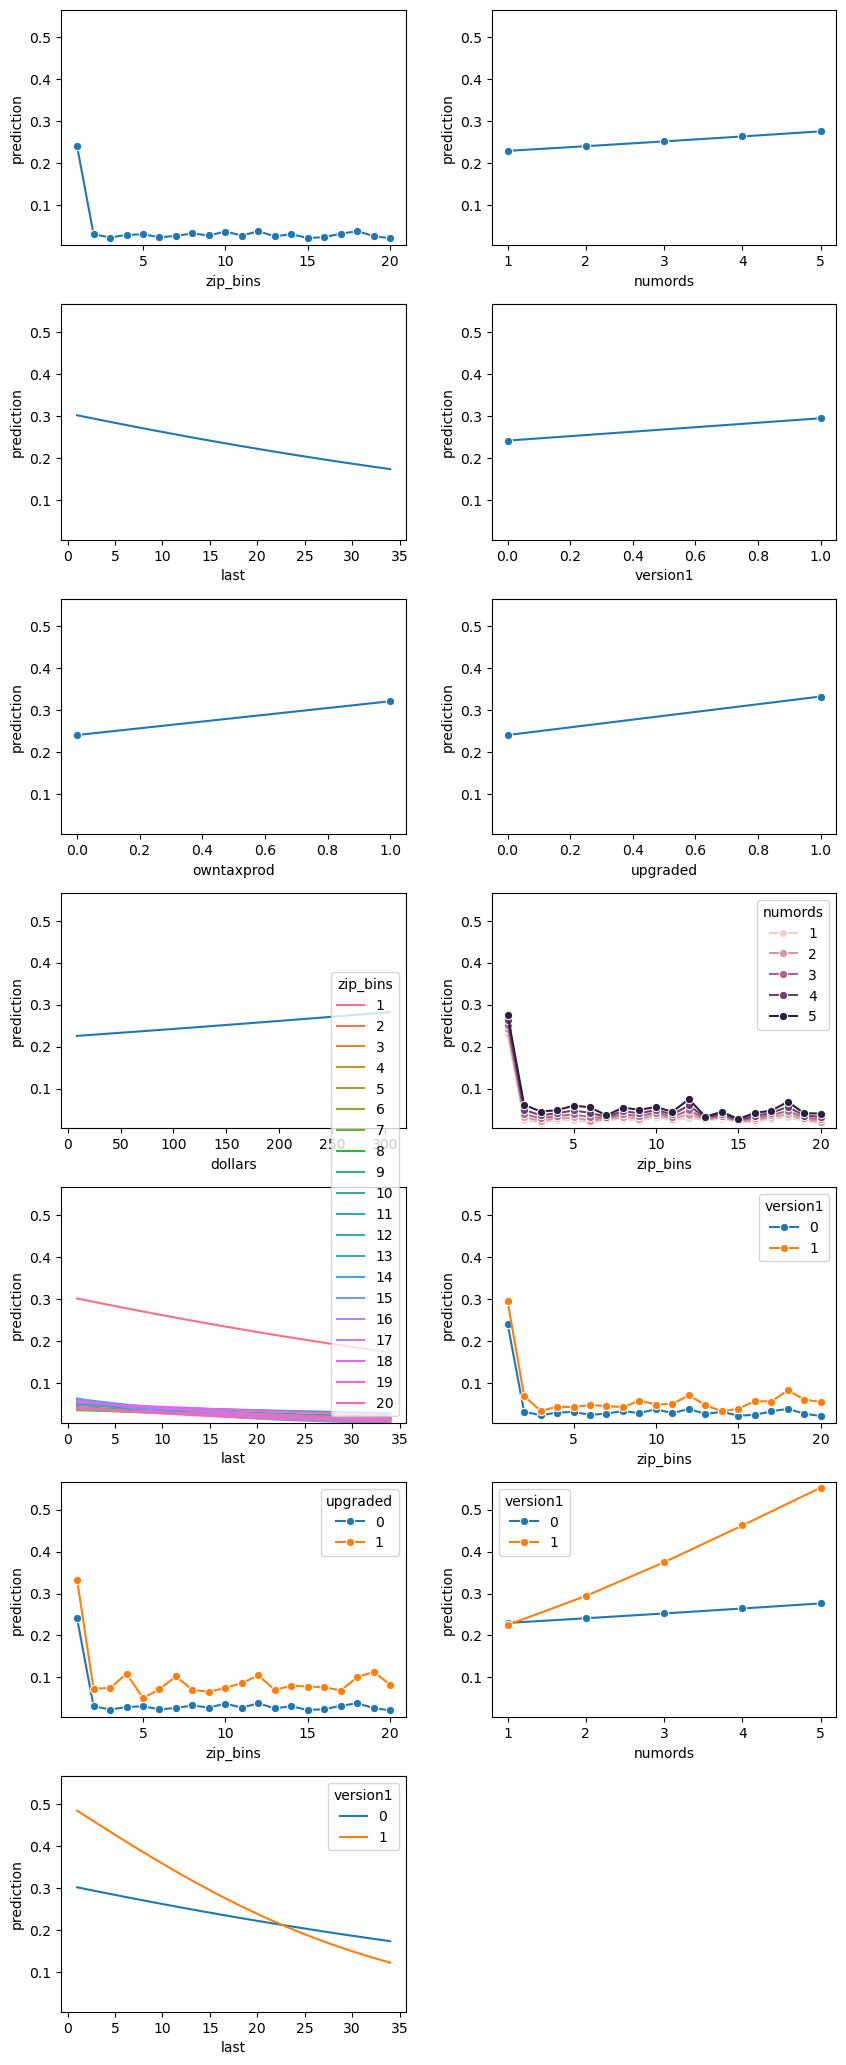

In [65]:
lrM12.plot("pred", incl_int=["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded", "numords:version1", "last:version1"])

The prediction plots illustrate how the predicted probability of businesses responding to a QuickBooks upgrade offer changes with different predictor variables, holding all other variables constant.

Holding all other variables constant:
- **zip_bins:** The non-linear relationship with a sharp decline after the first bin suggests that businesses in the first bin are significantly more likely to respond than those in other bins, with the response probability evening out across the remaining bins.

- **numords:** The positive linear relationship between the number of orders and the predicted probability of response indicates that businesses with more previous orders are more likely to respond to the upgrade offer.

- **last:** The decreasing trend suggests that the longer it has been since the last order, the less likely a business is to respond.

- **version1:** Businesses using version 1 of QuickBooks are more likely to respond to the upgrade offer than those using another version.

- **owntaxprod:** Businesses that own tax products have a higher likelihood of responding than those that don't.

- **upgraded:** The increasing trend indicates that businesses that have previously upgraded are more likely to respond again.

- **dollars:** The increasing trend suggests that businesses that have spent more money are more likely to respond to the upgrade offer.

- **Interaction Plots:** The interactions between zip_bins and numords, zip_bins and last, zip_bins and version1, zip_bins and upgraded, numords and version1, and last and version 1 demonstrate that the effect of one variable on the prediction may depend on the level of another variable. For example, the impact of the time since the last order on whether the business is predicted to respond to the offer is dependent on whether the business is using version 1 of QuickBooks.

#### **Figure 2 : Permutation Importance Plot**

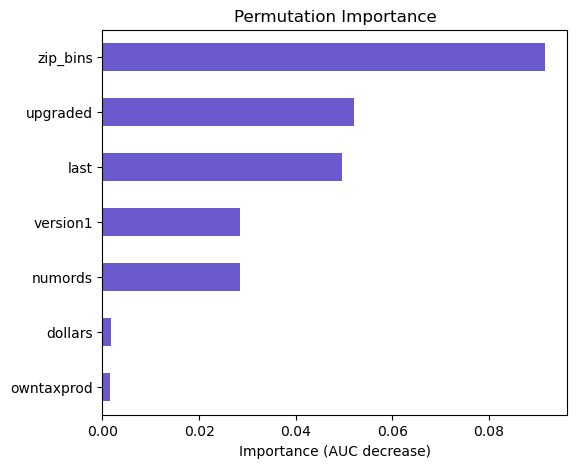

In [68]:
lrM12.plot("vimp")


The permutation importance of various predictors in a model is measured by the decrease in the Area Under the Curve (AUC) when each predictor variable is randomly shuffled. The length of the bar represents the extent to which the predictive accuracy of the model, as gauged by AUC, decreases when the information provided by that predictor is disrupted.

From the chart, zip_bins emerges as the most influential variable, indicating that geographical location has the highest impact on the model's predictions. Upgraded and last also show significant importance, suggesting that a business's history of software upgrades is a strong indicator of their likelihood to respond to the campaign, as is the time since the last order. 

Version1 and numords display moderate importance, with the version of QuickBooks in use and the number of orders being useful but less critical than location or upgrade history. 

Dollars and owntaxprod have the least importance among the variables included, suggesting that the amount of money spent and whether the business owns tax products are the least useful predictors for the model's performance in this context.

## Step 3: Model Evaluation

In [69]:
# Actual predictions 
intuit75k["pred_logit_wave1"] = lrM12.predict(data=intuit75k)["prediction"]

# Predictions for wave 2 (50% of probability of wave 1)
intuit75k["pred_logit_wave2"] = lrM12.predict(data=intuit75k)["prediction"] * 0.5

We predicted the probability of a positive response to the QuickBooks upsell campaign using the selected model (lrM12). The pred_logit_wave1 and pred_logit_wave2 columns were created in the intuit75k dataframe to store the predicted probabilities for wave 1 and wave 2 of the campaign, respectively.

The predicted probabilities for wave 2 are assumed to be 50% of the predicted probabilities for wave 1. This is based on the assumption that the probability of a business responding to the upsell campaign is lower for the second wave than the first wave, as the businesses that were most likely to respond have already done so.

In [70]:
# Decile predictions for wave 1 grouped by training
intuit75k["pred_logit_dec"] = (
    intuit75k
    .groupby("training")
    .pred_logit_wave1
    .transform(rsm.xtile, 10, rev=True)
)

In [71]:
# Decile table for wave 1 predictions grouped by training
dec_tab = (
    intuit75k
    .groupby([ "training", "pred_logit_dec"])
    .agg(
        nr_obs=("pred_logit_wave1", "count"), 
        nr_responses=("res1_yes", lambda x: x.sum()),
        response_rate_wave1=("res1_yes", "mean"), 
    )
    .reset_index()
    .sort_values(by=["training", "pred_logit_dec"], ascending=[False, True]) 
)


In [72]:
dec_tab

,training,pred_logit_dec,nr_obs,nr_responses,response_rate_wave1
10,1,1,5250,997,0.189905
11,1,2,5250,409,0.077905
12,1,3,5249,283,0.053915
13,1,4,5251,204,0.038850
14,1,5,5250,173,0.032952
15,1,6,5250,138,0.026286
16,1,7,5249,101,0.019242
17,1,8,5251,82,0.015616
18,1,9,5250,72,0.013714
19,1,10,5250,39,0.007429


#### **Figure 3: Response Rate by Predicted Probability**

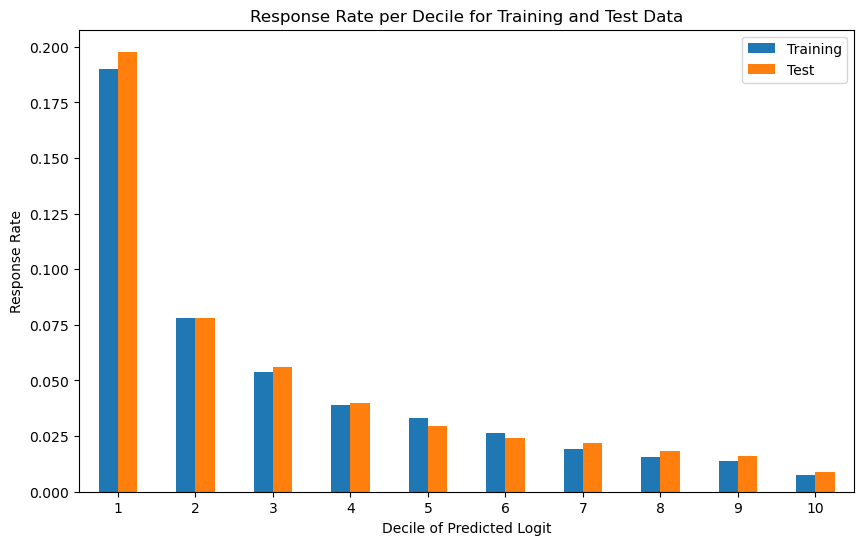

In [73]:
# Adjust the table to plot for both training and test data
dec_tab_adj = dec_tab.pivot(index='pred_logit_dec', columns='training', values='response_rate_wave1').reset_index()
dec_tab_adj.columns = ['pred_logit_dec', 'response_rate_wave1_test', 'response_rate_wave1_train']

# Plot the response rate per decile for training and test data
fig = dec_tab_adj.plot.bar(x='pred_logit_dec', y=['response_rate_wave1_train', 'response_rate_wave1_test'], rot=0, figsize=(10, 6))
fig.set_xlabel('Decile of Predicted Logit')
fig.set_ylabel('Response Rate')
fig.set_title('Response Rate per Decile for Training and Test Data')
fig.legend(["Training", "Test"])

Our objective is to evaluate the predictive performance of our selected model by analyzing the response rate across deciles of predicted probabilities. We segment predictions into ten groups (deciles) and computes the actual response rates for each, comparing the outcomes of the training and test datasets. The resulting bar chart visualizes these response rates, where ideally, higher deciles indicate a higher likelihood of response. The model appears to perform well, as the first decile shows the highest response rate, suggesting the model is effective in predicting those most likely to respond to the campaign.

In [74]:
# Lift table for wave 1 predictions grouped by training
lift_tab = dec_tab[['pred_logit_dec', 'training', 'nr_obs', 'nr_responses', 'response_rate_wave1']].copy()
lift_tab["cum_nr_obs"] = lift_tab.groupby('training')['nr_obs'].cumsum()
lift_tab["cum_nr_responses"] = lift_tab.groupby('training')['nr_responses'].cumsum()
lift_tab["cum_prop_obs"] = lift_tab.groupby('training')['cum_nr_obs'].transform(lambda x: x / x.iloc[-1])
lift_tab["cum_response_rate"] = lift_tab["cum_nr_responses"] / lift_tab["cum_nr_obs"]
overall_avg_response_rate = lift_tab.groupby('training').apply(lambda x: x['nr_responses'].sum() / x['nr_obs'].sum()).reset_index(name='overall_avg_response_rate')
lift_tab = lift_tab.merge(overall_avg_response_rate, on='training')
lift_tab["lift"] = lift_tab['response_rate_wave1'] / lift_tab.groupby('training')['response_rate_wave1'].transform('mean')
lift_tab["cum_lift"] = lift_tab["cum_response_rate"] / lift_tab['overall_avg_response_rate']

#### **Figure 4 : Cumulative Lift Plot**

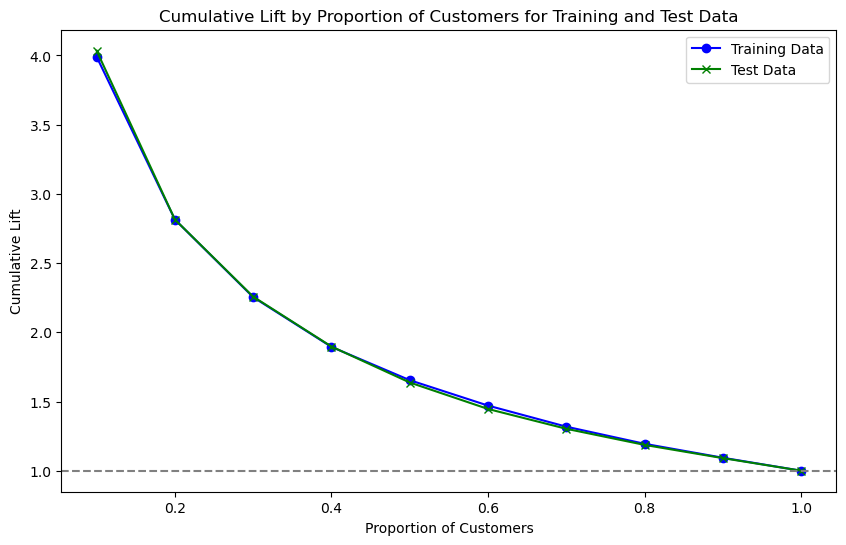

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))

training_data = lift_tab[lift_tab['training'] == 1]
test_data = lift_tab[lift_tab['training'] == 0]

ax.plot(training_data["cum_prop_obs"], training_data["cum_lift"], color='blue', marker='o', label='Training Data')
ax.plot(test_data["cum_prop_obs"], test_data["cum_lift"], color='green', marker='x', label='Test Data')

ax.axhline(1, color="gray", linestyle="--")
ax.set_xlabel("Proportion of Customers")
ax.set_ylabel("Cumulative Lift")
ax.set_title("Cumulative Lift by Proportion of Customers for Training and Test Data")
ax.legend()

plt.show()

The convergence of the training and test lines in the lift chart suggests that the model is stable and generalizes well. This means that the predictive performance observed during the training phase of the model is consistent when the model is applied to unseen data, in this case, the test dataset.

When both lines converge, it indicates that the model is not overfitted to the training data; instead, it maintains its predictive power across different datasets. This is a positive sign that the patterns the model learned from the training data hold true for the test data, implying that the model should perform similarly when predicting responses for new, future customers.

It is also worth noting that if the lines converge at a cumulative lift greater than 1, the model is considered to be adding value by improving the selection of respondents over a random guess. This consistency across both datasets can give confidence in the deployment of the model for practical use.

In [76]:
gains_tab = lift_tab[['pred_logit_dec', 'training', 'cum_prop_obs', 'nr_responses']].copy()
gains_tab['cum_nr_responses'] = gains_tab.groupby('training')['nr_responses'].transform('cumsum')
gains_tab["gains"] = gains_tab['nr_responses'] / gains_tab.groupby('training')['nr_responses'].transform('sum')
gains_tab["cum_gains"] = gains_tab['cum_nr_responses'] / gains_tab.groupby('training')['nr_responses'].transform('sum')

In [77]:
zero_row_training = pd.DataFrame({'pred_logit_dec': [0], 'training': [1], 'cum_prop_obs': [0], 'nr_responses': [0], 'cum_nr_responses': [0], 'gains': [0], 'cum_gains': [0]})
zero_row_test = pd.DataFrame({'pred_logit_dec': [0], 'training': [0], 'cum_prop_obs': [0], 'nr_responses': [0], 'cum_nr_responses': [0], 'gains': [0], 'cum_gains': [0]})

gains_tab = pd.concat([zero_row_training, zero_row_test, gains_tab], ignore_index=True)
gains_tab.sort_values(by=['training', 'pred_logit_dec'], inplace=True)
gains_tab.reset_index(drop=True, inplace=True)

#### **Figure 5: Cumulative Gains Chart**

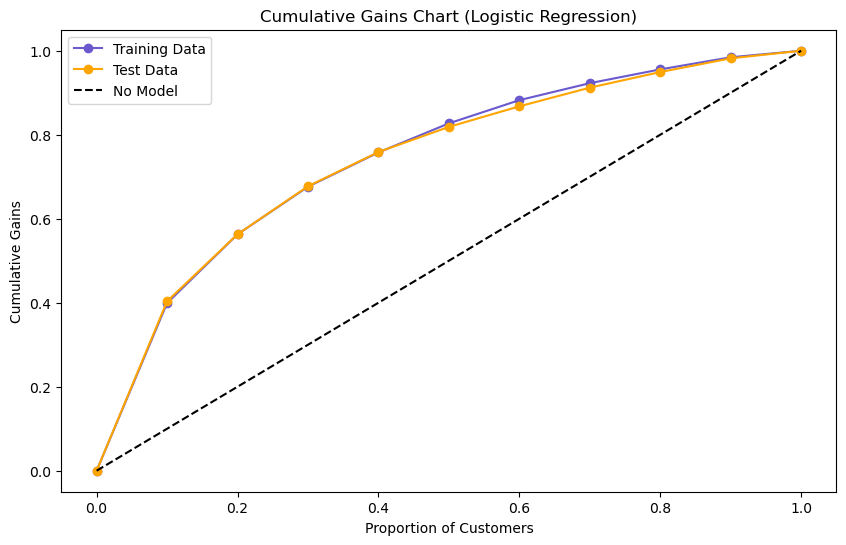

In [78]:
training_data = gains_tab[gains_tab['training'] == 1]
test_data = gains_tab[gains_tab['training'] == 0]

plt.figure(figsize=(10, 6))

plt.plot(training_data['cum_prop_obs'], training_data['cum_gains'], color='slateblue', label='Training Data', marker='o')
plt.plot(test_data['cum_prop_obs'], test_data['cum_gains'], color='orange', label='Test Data', marker='o')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='No Model')
plt.xlabel('Proportion of Customers')
plt.ylabel('Cumulative Gains')
plt.title('Cumulative Gains Chart (Logistic Regression)')
plt.legend()
plt.show()


The Cumulative Gains Chart demonstrates that the logistic regression model significantly outperforms random selection (as indicated by its distance above the 'No Model' line), suggesting it has good predictive power. The parallel trajectories of the training and test data curves indicate that the model generalizes well and is not overfitting. This is further evidenced as both lines converge towards the end, implying that the model's predictive performance is consistent across unseen data, which is indicative of its robustness and reliability for practical application.

In [79]:
cost = 1.41
margin = 60

breakeven = cost / margin

print(f"Breakeven Response Rate: {breakeven:.2%}")

Breakeven Response Rate: 2.35%


In [80]:
intuit75k["mail_wave1"] = intuit75k.pred_logit_wave1 > breakeven

We used the breakeven analysis to determine the optimal cutoff probability for the QuickBooks upsell campaign. The breakeven analysis calculates the probability threshold at which the expected profit from the campaign equals the cost of the campaign. The optimal cutoff probability is 0.0235, which is the probability at which the expected profit from the campaign equals the cost of the campaign. This means that the company should only send the upsell campaign to businesses with a predicted probability of response greater than 0.0235. It is important to note that this mailout strategy is assuming that the businesses will respond to the campaign with the same probability as the mail-1 campaign. Since the response probability for mail-2 is expected to be half of mail-1, the cutoff probability for mail-2 should be adjusted accordingly.

In [81]:
# Confusion matrix for wave 1
cm_logit = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [
            intuit75k[(intuit75k.training == 0) & (intuit75k.res1_yes == 1) & (intuit75k.mail_wave1 == True)].shape[0],
            intuit75k[(intuit75k.training == 0) & (intuit75k.res1_yes == 0) & (intuit75k.mail_wave1 == True)].shape[0],
            intuit75k[(intuit75k.training == 0) & (intuit75k.res1_yes == 0) & (intuit75k.mail_wave1 == False)].shape[0],
            intuit75k[(intuit75k.training == 0) & (intuit75k.res1_yes == 1) & (intuit75k.mail_wave1 == False)].shape[0],
        ]
    }
)

cm_logit

,label,nr
0,TP,1031
1,FP,16122
2,TN,5275
3,FN,72


#### **Figure 6: Confusion Matrix**

In [82]:
# Metrics for wave 1
accuracy = (cm_logit.nr[0] + cm_logit.nr[2]) / cm_logit.nr.sum()

recall = cm_logit.nr[0] / (cm_logit.nr[0] + cm_logit.nr[3])

precision = cm_logit.nr[0] / (cm_logit.nr[0] + cm_logit.nr[1])

specificity = cm_logit.nr[2] / (cm_logit.nr[1] + cm_logit.nr[2])

print(f"Accuracy: {accuracy:.2%},\nRecall: {recall:.2%},\nPrecision: {precision:.2%},\nSpecificity: {specificity:.2%}")


Accuracy: 28.03%,
Recall: 93.47%,
Precision: 6.01%,
Specificity: 24.65%


- **Accuracy (28.03%):** indicates the overall percentage of correct predictions (both true positives and true negatives) by the model. A low accuracy in this context suggests that the model is not effective in correctly identifying both responders and non-responders to the campaign.

- **Recall (93.47%):** reflects the model's ability to identify actual responders. High recall means the model is good at capturing most customers who would respond positively to the upsell campaign but at the cost of also capturing many who would not (as indicated by the low precision).

- **Precision (6.01%):** measures the proportion of true positives among all positives predicted by the model. Low precision, as seen here, indicates that a small percentage of the predicted responders actually respond to the campaign, leading to a high number of false positives.

- **Specificity (24.65%):** shows the model's ability to identify actual non-responders. The low specificity here means the model incorrectly identifies a large portion of non-responders as responders.

The effectiveness of the campaign, as dictated by these metrics, is financially challenging. The high recall ensures most actual responders are targeted, but the extremely low precision indicates a high cost for each actual responder due to the large number of non-responders also being targeted. This approach results in a substantial expenditure on non-responders, which might outweigh the revenue generated from the responders, especially when the mailing cost is considered at scale. The low specificity further exacerbates this issue, as it indicates that a large portion of non-responders are incorrectly identified as responders, leading to further unnecessary expenditure. However, since customers can only purchase the upgrade if they are sent the mail, Intuit may be willing to accept a low precision in order to capture as many potential responders as possible.

In [85]:
def perf_calc_training(dat, intro="", mail="", perf="res1", lev="Yes"):
    """A function to calculate the performance of the model on the training data."""
    cost_mail = 1.41
    margin = 60
    dat = dat[((dat["training"] == 1) | ((dat["training"] == 0) & (dat[perf] == "Yes")))] 
    perc_mail = dat[mail].mean()
    dat = dat[dat[mail]]
    nr_mail = dat.shape[0]
    response_rate = (dat[perf] == lev).mean()
    nr_responses = (dat[perf] == lev).sum()
    revenue = nr_responses * margin
    total_mail_cost = nr_mail * cost_mail
    profit = revenue - total_mail_cost
    ROME = profit / total_mail_cost
    
    prn = f"""
        - {intro} the number of customers Intuit should target is {(nr_mail):,.0f} ({100 * perc_mail:.2f}%)
        - The response rate for the selected customers is predicted to be {100 * response_rate:.2f}% or {nr_responses:,.0f} responses
        - The revenue is equal to ${revenue:,.2f}
        - The expected profit is ${profit:,.2f}
        - The total mailing cost is estimated to be ${total_mail_cost:,.2f} with a ROME of {100 * ROME:.2f}%
        """
        
    print(prn)
    
    return response_rate, perc_mail

In [109]:
perf_calc_training(intuit75k, intro="With the logistic targeting model", mail="mail_wave1", perf="res1", lev="Yes")


        - With the logistic targeting model the number of customers Intuit should target is 40,872 (76.25%)
        - The response rate for the selected customers is predicted to be 8.30% or 3,392 responses
        - The revenue is equal to $203,520.00
        - The expected profit is $145,890.48
        - The total mailing cost is estimated to be $57,629.52 with a ROME of 253.15%
        


(0.08299080054805245, 0.7624946364942261)

We measured the performance that the model would have achieved on the training data in order to obtain an expected response rate. For this, we used the predicted probabilities for the wave-1 mailing campaign, since the actual response data we have represents the wave-1 campaign. The expected response rate is 8.3%, which means that we expect 8.3% of the businesses that we mail to respond to the upsell campaign. We can use this expected response rate to calculate the expected profit from the campaign.

In [111]:
def perf_calc_test(dat, response_rate, intro="", mail="", perf="res1", lev="Yes"):
    """A function to calculate the performance of the model on the test data."""
    cost_mail = 1.41
    margin = 60
    dat = dat[(dat["training"] == 0) & (dat["res1"] == "No")]
    perc_mail = dat[mail].mean()
    dat = dat[dat[mail]]
    nr_mail = dat.shape[0]
    nr_responses = nr_mail * response_rate
    revenue = nr_responses * margin
    total_mail_cost = nr_mail * cost_mail
    profit = revenue - total_mail_cost
    ROME = profit / total_mail_cost
    
    prn = f"""
        - {intro} the number of customers Intuit should target is {(nr_mail):,.0f} ({100 * perc_mail:.2f}%)
        - The response rate for the selected customers is predicted to be {100 * response_rate:.2f}% or {nr_responses:,.0f} responses
        - The revenue is equal to ${revenue:,.2f}
        - The expected profit is ${profit:,.2f}
        - The total mailing cost is estimated to be ${total_mail_cost:,.2f} with a ROME of {100 * ROME:.2f}%
        """
        
    print(prn)
    
    return response_rate, perc_mail

In [108]:
intuit75k["mail_wave2"] = intuit75k.pred_logit_wave2 > breakeven

Here, we determine which businesses to mail by selecting those with a predicted probability of response greater than the optimal cutoff probability of 0.0235. This time we used the predicted response probabilities for the wave-2 mailing campaign, which were adjusted by multiplying the wave-1 predictions by 50%. This is based on the decision rule that responses in wave 2 are expected to be half as likely as in wave 1. As a result, the number of businesses we target in wave 2 is less than we would have targeted in wave 1.

In [113]:
perf_calc_test(intuit75k, response_rate=0.08299080054805245, intro="With the logistic targeting model", mail="mail_wave2", perf="res1", lev="Yes")


        - With the logistic targeting model the number of customers Intuit should target is 8,520 (39.82%)
        - The response rate for the selected customers is predicted to be 8.30% or 707 responses
        - The revenue is equal to $42,424.90
        - The expected profit is $30,411.70
        - The total mailing cost is estimated to be $12,013.20 with a ROME of 253.15%
        


(0.08299080054805245, 0.39818666168154415)

Using the expected response rate of ~8.3% and the cost of the campaign, we calculated the expected profit from the campaign for the test data. Here, we used the targeted businesses for the wave-2 mailing campaign, since we expect the response rate to be lower than for wave 1. From the test data, Intuit should target 8,520 businesses for the wave-2 mailing campaign in order to maximize the expected profit from the campaign. With the expected response rate of 8.3%, we expect to receive 707 positive responses, earning a profit of $30,412 with an ROME of 253.15%.

In [95]:
def perf_calc_campaign (response_rate=0.0845982086856168, intro="", perf="res1", lev="Yes", perc_mail=0.39818666168154415, nr_cust=801821, nr_res1= 38487):
    cost_mail = 1.41
    margin = 60
    available_cust = nr_cust - nr_res1
    nr_mail = available_cust * perc_mail
    nr_responses = nr_mail * response_rate
    revenue = nr_responses * margin
    total_mail_cost = nr_mail * cost_mail
    profit = revenue - total_mail_cost
    ROME = profit / total_mail_cost
    
    prn = f"""
        - {intro} the number of customers Intuit should target is {(nr_mail):,.0f} ({100 * perc_mail:.2f}%)
        - The response rate for the selected customers is predicted to be {100 * response_rate:.2f}% or {nr_responses:,.0f} responses
        - The revenue is equal to ${revenue:,.2f}
        - The expected profit is ${profit:,.2f}
        - The total mailing cost is estimated to be ${total_mail_cost:,.2f} with a ROME of {100 * ROME:.2f}%
        """
        
    print(prn)

In [115]:
perf_calc_campaign(response_rate=0.08299080054805245, intro="With the logistic targeting model", perf="res1", lev="Yes", perc_mail=0.39818666168154415, nr_cust=801821, nr_res1= 38487)


        - With the logistic targeting model the number of customers Intuit should target is 303,949 (39.82%)
        - The response rate for the selected customers is predicted to be 8.30% or 25,225 responses
        - The revenue is equal to $1,513,500.33
        - The expected profit is $1,084,931.65
        - The total mailing cost is estimated to be $428,568.68 with a ROME of 253.15%
        


Using the response rate from the training data, and the percentage of the customer base that we chose to target from the test data, we can extrapolate what the overall performance of the direct mail campaign would be for a larger customer base, excluding those who have already responded. We expect to target 303,949 businesses, which is 39.82% of the remaining customer base. This targeting is expected to result in 25,225 positive responses, generating a profit of $1,084,932 and an ROME of 253.15%.

In [116]:
# Create a DataFrame with the id's of the target customers
mail_id = intuit75k[intuit75k.training == 0][["id", "mail_wave2"]].rename(columns={"mail_wave2": "mailto_wave2"})

# Save the mail_id to a csv file
mail_id.to_csv("Group17_Intuit.csv", index=False)

## Neural Network

### Classifiers

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

#ensemble learning

# Selecting features and target variable
X = intuit75k.drop(['id', 'res1','res1_yes','sex'], axis=1) 

#y has to be res1_yes and training as columns to filter data later
y = intuit75k[['res1_yes','training']]

# Splitting the data into training and test sets
X_train = X[X['training'] == 1]
X_test = X[X['training'] == 0]
y_train = y[y['training'] == 1]['res1_yes']
y_test = y[y['training'] == 0]['res1_yes']

#drop the training variable
X_train = X_train.drop(['training'], axis=1)
X_test = X_test.drop(['training'], axis=1)

SEED = 123

#decision tree
dt = DecisionTreeClassifier(random_state=SEED, max_depth=8, criterion='entropy', min_samples_leaf=0.1, max_features=0.8)

#KNN
knn = KNeighborsClassifier(n_neighbors=40)

#RANDOM FOREST
rf = RandomForestClassifier(random_state=SEED, n_estimators=100, max_depth=8, min_samples_leaf=0.1, max_features=0.8)

classifiers = [('Decision Tree', dt), ('K Nearest Neighbours', knn), ('Random Forest', rf)]

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:
    # Fit clf to the training set
    clf.fit(X_train, y_train)
    
    # Predict probabilities for the positive class
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Print the AUC
    print('{:s} : {:.3f}'.format(clf_name, auc))

# Predict probabilities for the voting classifier
vc_soft = VotingClassifier(estimators=classifiers, voting='soft')
vc_soft.fit(X_train, y_train) 

# Then predict probabilities and calculate AUC
y_pred_prob_vc = vc_soft.predict_proba(X_test)[:, 1]
auc_vc = roc_auc_score(y_test, y_pred_prob_vc)
print('Voting Classifier AUC: {:.3f}'.format(auc_vc))



Decision Tree : 0.701
K Nearest Neighbours : 0.636
Random Forest : 0.698
Voting Classifier AUC: 0.713



- Since the response variable is binary, we decided to work with classification models. We used the following classifiers: Decision Tree, K Nearest Neighbours, and Random Forest. 
- We tuned the hyperparameters of the Decision Tree to find the best model. We used the following hyperparameters: max_depth, min_samples_split, and min_samples_leaf. For the K Nearest Neighbours classifier, we used the hyperparameter n_neighbors. For the Random Forest classifier, we used the hyperparameters n_estimators, max_depth, min_samples_split, and min_samples_leaf.
- We used the AUC to evaluate the performance of the classifiers. We also used the Voting Classifier to see if the AUC would improve.
- The AUC of the Decision Tree, K Nearest Neighbours, and Random Forest classifiers are 0.737, 0.636, and 0.742, respectively. The AUC of the Voting Classifier is 0.740. The Random Forest classifier has the highest AUC, but in comparison to our Logistic Regression model, the AUC is lower. Therefore, we will stick with our Logistic Regression model.

- Reasoning for testing these classifiers: We chose these classifiers because they are simple and easy to interpret. We also wanted to see if the Voting Classifier would improve the AUC of the individual classifiers. 

### NN Model

In [ ]:
import pyrsm as rsm
import matplotlib as mpl

# increase plot resolution
mpl.rcParams["figure.dpi"] = 100

In [ ]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

In [ ]:
df_train = intuit75k[((intuit75k["training"] == 1) | ((intuit75k["training"] == 0) & (intuit75k["res1_yes"] == 1)))]
df_valid  = intuit75k[(intuit75k["training"] == 0) & (intuit75k["res1"] == "No")]

In [ ]:
evars = ["zip_bins","sex", "bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"]

In [ ]:
clf1 = rsm.model.mlp(
    data={"intuit": df_train}, rvar="res1_yes", lev=1, evar = evars,
    hidden_layer_sizes = (1,),
    solver = "adam",
    learning_rate_init = 0.001
)
clf1.summary()

Multi-layer Perceptron (NN)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, sex, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded
Model type           : classification
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : adam
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum itterations  : 10000
random_state         : 1234
AUC                  : 0.754

Raw data             :
zip_bins  sex  bizflag  numords  dollars  last  sincepurch  version1  owntaxprod  upgraded
      18 Male        0        2    109.5     5          12         0           0         0
       1 Male        0        1     22.0    17           1         0           0         0
       3 Male        0        1     20.0    17          17         0           0         1
      11 Male        1        1     24.5     4          17         1           0        

In [ ]:
intuit75k['pred_nn1'] = clf1.predict(intuit75k)["prediction"]

In [ ]:
clf2 = rsm.model.mlp(
    data={"intuit": df_train}, rvar="res1_yes", lev=1, 
    evar= evars,
    hidden_layer_sizes = (2,),
    solver = "adam",
    learning_rate_init = 0.001
)
clf2.summary()


Multi-layer Perceptron (NN)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, sex, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded
Model type           : classification
Hidden_layer_sizes   : (2,)
Activation function  : tanh
Solver               : adam
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum itterations  : 10000
random_state         : 1234
AUC                  : 0.758

Raw data             :
zip_bins  sex  bizflag  numords  dollars  last  sincepurch  version1  owntaxprod  upgraded
      18 Male        0        2    109.5     5          12         0           0         0
       1 Male        0        1     22.0    17           1         0           0         0
       3 Male        0        1     20.0    17          17         0           0         1
      11 Male        1        1     24.5     4          17         1           0        

In [ ]:
intuit75k['pred_nn2'] = clf2.predict(intuit75k)["prediction"]

In [ ]:
intuit75k

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,biz_zip,pred_nn1,pred_nn2,pred_nn10_10,pred_nn10_5,pred_nn_f,mail_wave1_nn,mail_wave2_nn,res2_yes,haha
0,1,94553,18,Male,0,2,109.5,5,12,0,...,0_18,0.055383,0.055027,0.048610,0.049123,0.051559,True,True,True,1
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,0_10,0.033376,0.031333,0.043963,0.050018,0.047049,True,True,True,1
2,3,37091,8,Male,0,4,93.0,14,29,0,...,0_8,0.108678,0.122334,0.115820,0.120372,0.110644,True,True,True,1
3,4,02125,1,Male,0,1,22.0,17,1,0,...,0_1,0.116521,0.121735,0.173459,0.232517,0.193581,True,True,True,1
4,5,60201,11,Male,0,1,24.5,2,3,0,...,0_11,0.037142,0.034443,0.048165,0.053094,0.042613,True,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,74996,28205,6,Male,1,4,211.5,5,15,0,...,1_6,0.068928,0.078551,0.058548,0.067872,0.071046,True,True,True,1
74996,74997,94806,18,Male,0,1,4.5,35,34,1,...,0_18,0.030455,0.025469,0.024469,0.056224,0.017901,False,False,True,1
74997,74998,72958,13,Female,1,1,54.5,4,19,1,...,1_13,0.062749,0.059462,0.067205,0.076289,0.052227,True,True,True,1
74998,74999,29464,6,Male,0,1,69.5,20,27,0,...,0_6,0.042686,0.057642,0.043589,0.056724,0.047215,True,True,True,1


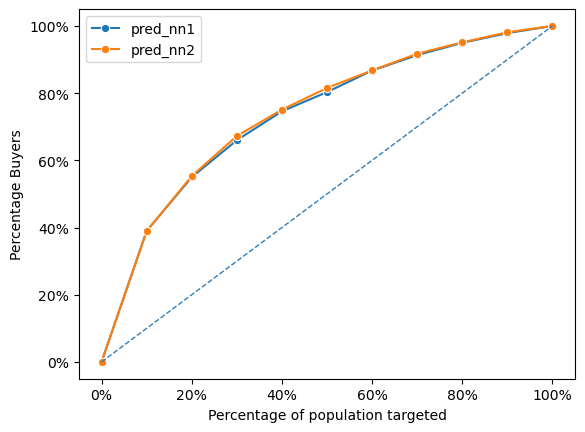

In [ ]:
fig = rsm.gains_plot(
    intuit75k, 
    "res1_yes", 1,
    [ "pred_nn1", "pred_nn2"]
)

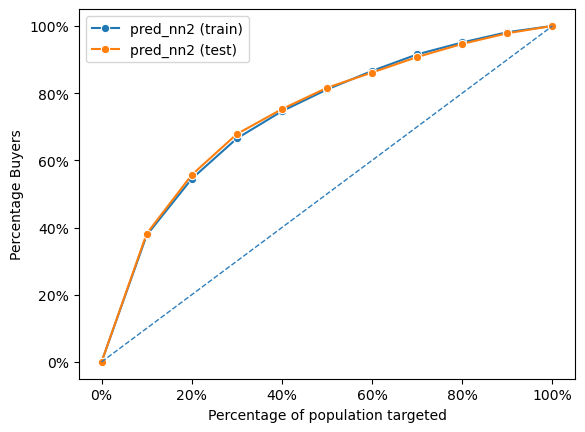

In [ ]:
dct = {"train": df_train ,
       "test": intuit75k[(intuit75k["training"] == 0)]}
fig = rsm.gains_plot(dct, "res1_yes", 1, "pred_nn2")

In [ ]:
clf3 = rsm.model.mlp(
    data={"intuit": df_train}, rvar="res1_yes", lev=1, 
    evar= evars,
    hidden_layer_sizes = (10,10,),
    solver = "adam",
    learning_rate_init = 0.001
)
clf3.summary()

Multi-layer Perceptron (NN)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, sex, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded
Model type           : classification
Hidden_layer_sizes   : (10, 10)
Activation function  : tanh
Solver               : adam
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum itterations  : 10000
random_state         : 1234
AUC                  : 0.767

Raw data             :
zip_bins  sex  bizflag  numords  dollars  last  sincepurch  version1  owntaxprod  upgraded
      18 Male        0        2    109.5     5          12         0           0         0
       1 Male        0        1     22.0    17           1         0           0         0
       3 Male        0        1     20.0    17          17         0           0         1
      11 Male        1        1     24.5     4          17         1           0    

In [ ]:
intuit75k['pred_nn10_10'] = clf3.predict(intuit75k)["prediction"]

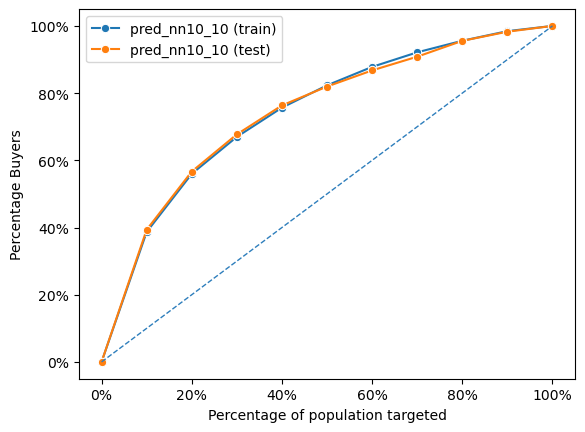

In [ ]:
dct = {"train": df_train, "test": intuit75k[intuit75k.training == 0]}
fig = rsm.gains_plot(dct, "res1_yes", 1, "pred_nn10_10")

In [ ]:
clf4 = rsm.model.mlp(
    data={"intuit": df_train}, rvar="res1_yes", lev=1, 
    evar= evars,
    hidden_layer_sizes = (10,5,),
    solver = "adam",
    learning_rate_init = 0.001
)
clf4.summary()

Multi-layer Perceptron (NN)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, sex, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded
Model type           : classification
Hidden_layer_sizes   : (10, 5)
Activation function  : tanh
Solver               : adam
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum itterations  : 10000
random_state         : 1234
AUC                  : 0.771

Raw data             :
zip_bins  sex  bizflag  numords  dollars  last  sincepurch  version1  owntaxprod  upgraded
      18 Male        0        2    109.5     5          12         0           0         0
       1 Male        0        1     22.0    17           1         0           0         0
       3 Male        0        1     20.0    17          17         0           0         1
      11 Male        1        1     24.5     4          17         1           0     

In [ ]:
intuit75k['pred_nn10_5'] = clf4.predict(intuit75k)["prediction"]

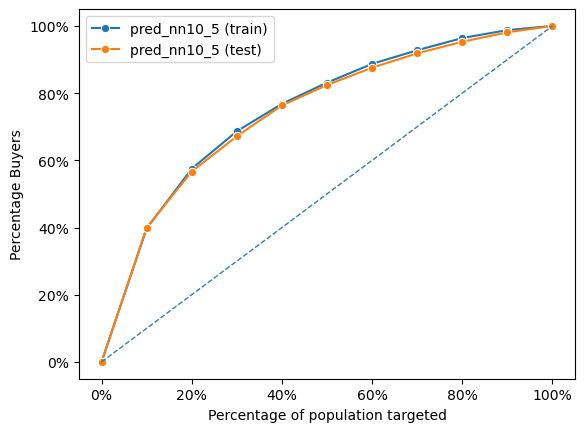

In [ ]:
dct = {"train": intuit75k[intuit75k.training == 1], "test": intuit75k[intuit75k.training == 0]}
fig = rsm.gains_plot(dct, "res1_yes", 1, "pred_nn10_5")

## Model tuning


In [ ]:
from sklearn.model_selection import GridSearchCV


hls = [(10,), (12,), (15,), (10, 10), (12, 10)]

param_grid = {"hidden_layer_sizes": hls}
scoring = {"AUC": "roc_auc"}

clf_cv = GridSearchCV (
    clf1.fitted, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
)

In [ ]:
clf1.data_onehot.mean().round(3)
clf1.data.res1_yes

0        0.0
3        0.0
5        0.0
7        0.0
9        0.0
        ... 
74994    0.0
74995    1.0
74996    0.0
74997    0.0
74998    0.0
Name: res1_yes, Length: 53603, dtype: float64

In [ ]:
clf_cv.fit(clf1.data_onehot, clf1.data.res1_yes)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                                     max_iter=10000, random_state=1234),
             n_jobs=4,
             param_grid={'hidden_layer_sizes': [(10,), (12,), (15,), (10, 10),
                                                (12, 10)]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [ ]:
pd.DataFrame(clf_cv.cv_results_).iloc[:, 5:].sort_values("rank_test_AUC")

,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
0,"{'hidden_layer_sizes': (10,)}",0.749741,0.771945,0.754780,0.746606,0.753825,0.755379,0.008786,1
3,"{'hidden_layer_sizes': (10, 10)}",0.749444,0.772747,0.753522,0.746942,0.754010,0.755333,0.009093,2
2,"{'hidden_layer_sizes': (15,)}",0.750550,0.770725,0.754285,0.749938,0.749523,0.755004,0.008040,3
1,"{'hidden_layer_sizes': (12,)}",0.747992,0.769539,0.757050,0.750193,0.748833,0.754721,0.008068,4
4,"{'hidden_layer_sizes': (12, 10)}",0.747426,0.772632,0.758017,0.742672,0.750228,0.754195,0.010477,5


In [ ]:
clf_cv.best_params_

{'hidden_layer_sizes': (10,)}

In [ ]:
clf_cv.best_score_.round(3)

0.755

In [ ]:
#final 
clf_f = rsm.model.mlp(
    data={"intuit": df_train}, rvar="res1_yes", lev=1, 
    evar= evars,
    hidden_layer_sizes = (10,),
    solver = "adam",
    learning_rate_init = 0.001
)
clf_f.summary()

Multi-layer Perceptron (NN)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, sex, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded
Model type           : classification
Hidden_layer_sizes   : (10,)
Activation function  : tanh
Solver               : adam
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum itterations  : 10000
random_state         : 1234
AUC                  : 0.765

Raw data             :
zip_bins  sex  bizflag  numords  dollars  last  sincepurch  version1  owntaxprod  upgraded
      18 Male        0        2    109.5     5          12         0           0         0
       1 Male        0        1     22.0    17           1         0           0         0
       3 Male        0        1     20.0    17          17         0           0         1
      11 Male        1        1     24.5     4          17         1           0       

In [ ]:
intuit75k['pred_nn_f'] = clf_f.predict(intuit75k)["prediction"]

In [ ]:
from sklearn import metrics

# prediction on training set
pred = intuit75k.loc[intuit75k.training == 1, "pred_nn_f"]
actual = rsm.ifelse(intuit75k.loc[intuit75k.training == 1, "res1_yes"] == 1, 1, 0)
fpr, tpr, thresholds = metrics.roc_curve(actual, pred)
metrics.auc(fpr, tpr).round(3)

0.766

In [ ]:
# prediction on test set
pred = intuit75k.loc[intuit75k.training == 0, "pred_nn_f"]
actual = rsm.ifelse(intuit75k.loc[intuit75k.training == 0, "res1_yes"] == 1, 1, 0)
fpr, tpr, thresholds = metrics.roc_curve(actual, pred)
metrics.auc(fpr, tpr).round(3)


0.761

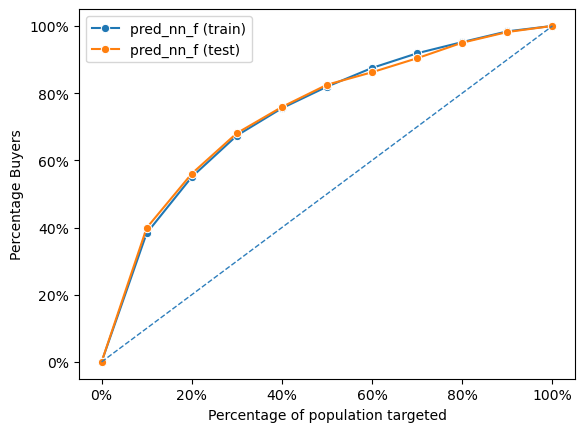

In [ ]:
dct = {"train": df_train, "test": intuit75k[intuit75k.training == 0]}
fig = rsm.gains_plot(dct, "res1_yes", 1, "pred_nn_f")

In [ ]:
cost = 1.41
margin = 60

breakeven = cost / margin

print(f"Breakeven Response Rate: {breakeven:.2%}")

Breakeven Response Rate: 2.35%


In [ ]:
intuit75k["mail_wave1_nn"] = intuit75k.pred_nn_f > breakeven
intuit75k["mail_wave2_nn"] = intuit75k.pred_nn_f * 0.50 > breakeven

In [ ]:
def perf_calc_training(dat, intro="", mail="", perf="res1", lev="Yes"):
    """A function to calculate the performance of the model on the training data."""
    cost_mail = 1.41
    margin = 60
    dat = dat[((dat["training"] == 1) | ((dat["training"] == 0) & (dat[perf] == "Yes")))] 
    perc_mail = dat[mail].mean()
    dat = dat[dat[mail]]
    nr_mail = dat.shape[0]
    response_rate = (dat[perf] == lev).mean()
    nr_responses = (dat[perf] == lev).sum()
    revenue = nr_responses * margin
    total_mail_cost = nr_mail * cost_mail
    profit = revenue - total_mail_cost
    ROME = profit / total_mail_cost
    
    prn = f"""
        - {intro} the number of customers Intuit should target is {(nr_mail):,.0f} ({100 * perc_mail:.2f}%)
        - The response rate for the selected customers is predicted to be {100 * response_rate:.2f}% or {nr_responses:,.0f} responses
        - The revenue is equal to ${revenue:,.2f}
        - The expected profit is ${profit:,.2f}
        - The total mailing cost is estimated to be ${total_mail_cost:,.2f} with a ROME of {100 * ROME:.2f}%
        """
        
    print(prn)
    
    return response_rate, perc_mail

In [ ]:
perf_calc_training(intuit75k, intro="With the NN targeting model", mail="mail_wave1_nn", perf="res1", lev="Yes")


        - With the NN targeting model the number of customers Intuit should target is 40,891 (76.28%)
        - The response rate for the selected customers is predicted to be 8.28% or 3,387 responses
        - The revenue is equal to $203,220.00
        - The expected profit is $145,563.69
        - The total mailing cost is estimated to be $57,656.31 with a ROME of 252.47%
        


(0.08282996258345357, 0.7628490942671119)

In [ ]:
def perf_calc_test(dat, response_rate, intro="", mail="", perf="res1", lev="Yes"):
    """A function to calculate the performance of the model on the test data."""
    cost_mail = 1.41
    margin = 60
    dat = dat[(dat["training"] == 0) & (dat["res1"] == "No")]
    perc_mail = dat[mail].mean()
    dat = dat[dat[mail]]
    nr_mail = dat.shape[0]
    nr_responses = nr_mail * response_rate
    revenue = nr_responses * margin
    total_mail_cost = nr_mail * cost_mail
    profit = revenue - total_mail_cost
    ROME = profit / total_mail_cost
    
    prn = f"""
        - {intro} the number of customers Intuit should target is {(nr_mail):,.0f} ({100 * perc_mail:.2f}%)
        - The response rate for the selected customers is predicted to be {100 * response_rate:.2f}% or {nr_responses:,.0f} responses
        - The revenue is equal to ${revenue:,.2f}
        - The expected profit is ${profit:,.2f}
        - The total mailing cost is estimated to be ${total_mail_cost:,.2f} with a ROME of {100 * ROME:.2f}%
        """
        
    print(prn)
    
    

In [ ]:
perf_calc_test(intuit75k, response_rate=0.08282996258345357, intro="With the NN targeting model", mail="mail_wave2_nn", perf="res1", lev="Yes")


        - With the NN targeting model the number of customers Intuit should target is 8,700 (40.66%)
        - The response rate for the selected customers is predicted to be 8.28% or 721 responses
        - The revenue is equal to $43,237.24
        - The expected profit is $30,970.24
        - The total mailing cost is estimated to be $12,267.00 with a ROME of 252.47%
        


- For the NN model we started with a simple model with 1 hidden layer. Then we increased the number of hidden layers and plot the gains_plot for the train and the test sets to check for overfitting as NN with more layers are prone to overfitting.
- We did a Grid Search to find the best hyperparameters for the NN model. The resulting best parameter was (10,) with the AUC as 0.755.
- We then got the AUC for the test set and it was 0.761. This is the best AUC we have gotten so far.
- Then we calculated the performance of our model by getting the profit for wave 1 prediction and then for wave 2 prediction. The profit for wave 2 was slightly higher than the logistic model. Even with that we would have the logistic model as the best model because it is easier to interpret and the AUC is not that different from the NN model.

### **Generative AI**

For this assignment, we used generative AI to help with the following:

1. Interpreting the logistic regression model output and understanding the results of the chi-squared test comparing the model with and without predictors for feature selection. ChatGPT was very helpful in explaining the outputs and confirming our understanding of the results.

- [Image1](images/1-logistic_output.png)

- [Image2](images/2-logistic_output2.png)


2. Directions on how to test for interactions between the predictors in the logistic regression model. This was a particularly part of this assignment, and ChatGPT was able to provide a step-by-step guide on how to search for and test for interactions between the predictors. We had a long dialogue on the topic of how to determine where to begin searching for interactions, and how to interpret the results of the tests for interactions. 

- [Image3](images/3-interactions1.png)

- [Image4](images/4-interactions2.png)

- [Image5](images/5-interactions3.png)

- [Image6](images/6-interactions4.png)

- [Image7](images/7-interactions5.png)

- [Image8](images/8-interactions6.png)

- [Image9](images/9-interactions7.png)

- [Image10](images/10-interactions8.png)


3. Writing a function to test for all potential interactions between predictors. After we had tested for interactions between the predictors in smaller groups, we wanted to write a function that would test for interactions between all predictors. ChatGPT was able to provide a step-by-step guide on how to write the function and how to interpret the results of the tests for interactions. It required a lot of back and forth to get the function right, but ChatGPT was able to deliver a working function in the end. 

- [Image11](images/11-interactionsfunction.png)

- [Image12](images/12-interactionsfunction2.png)

- [Image13](images/13-interactionsfunction3.png)


4. How to decide the correct order of operations for including or removing interactions. We wanted to know if there was a specific order in which we should include or remove interactions from the model. ChatGPT was able to provide guidance on this.

- [Image14](images/14-interactions8.png)

- [Image15](images/15-interactions9.png)

- [Image16](images/16-interactions10.png)

- [Image17](images/17-interactions11.png)

- [Image18](images/18-interactions12.png)


5. Help with code syntax, errors, and optimizing/simplifying code. ChatGPT is very helpful in quickly and accurately identifying syntax errors and resolving them. It was also able to provide guidance on how to optimize and simplify code.

- [Image19](images/19-code_error.png)

- [Image20](images/20-code_error2.png)

- [Image21](images/21-predictions.png)

- [Image22](images/22-predictions2.png)

- [Image23](images/23-optimize_code.png)


6. Questions about the benefits and drawbacks of different activation functions in neural networks. We asked ChatGPT about some of the use cases, benefits, and drawbacks of different activation functions in neural networks. ChatGPT was able to provide a detailed explanation of the different activation functions and their use cases.

- [Image24](images/24-activation_function.png)

- [Image25](images/25-activation_function2.png)


7. How to create decile/lift/gains table that groups the data by training vs test data. ChatGPT was able to help alter the code in order to add both the training and test data to the decile/lift/gains tables.

- [Image26](images/26-decile_table.png)

- [Image27](images/27-decile_table2.png)

- [Image28](images/28-deciletable3.png)

- [Image29](images/29-deciletable4.png)

- [Image30](images/30-deciletable5.png)


8. How to conduct a Lasso regression analysis, incorporating both individual predictors and their interaction terms, to enhance the predictive accuracy of our model. ChatGPT was unable to provide the necessary code for this. Even after multiple nudges, chat was unable to provide the correct code. Towards the end, ChatGPT gave me code that I wasn't able to decipher and so I abandoned the idea of using Lasso regression in this context.

- [Image31](images/2f43e8fa-3cfc-4bdd-bdfc-b8a50e4f7059.jpg)

- [Image32](images/23e3bfb5-864d-47e3-ae5a-6bb041e4e04f.jpg)

- [Image33](images/a96ee600-44cb-4be9-98ff-b66c5cf2ba8c.jpg)

9. I had difficulties interpreting the model training process for the Neural network. The issue  was that the training and test AUC are drastically different suggesting overfilling. But since I set the epochs 50, I don’t know what I do to to stop the training process. Chatgpt suggested to set up an early stop or break it manually. Another issues was to code through PyTorch. I have difficulties understanding the code, and I asked chat gpt to explain it for me. In general, it was very helpful.

- [Image34](images/34-nnmodel.jpeg)
- [Image35](images/35-nnmodel.jpeg)

10. When working on testing different classifiers, I had a hard time solving errors in the code. Chatgpt was able to help me solve the errors and also provided guidance on how to optimize the code.

- [Image36](images/36-Classifiers-error1.png)
- [Image36](images/36-Classifiers-error2.png)

11. Once I had the classifiers running, I had a loop to calculate the accuracy but for these models since I was using the AUC, I needed to change the code. Chatgpt was able to help me with the code.

- [Image37](images/37-Classifiers_auc_calc.png)

12. Moving on to building NN model, the part where we added adam solver was unfamilar to me. Chatgpt was able to help me undertsand the topic.

- [Image38](images/38-Adamsolver.png)

13. As we progressed with the NN model and landed on the topic of hyperparameter tuning, I Chat exaplined the concept of GridSearchCV and how to use it. Once added, it was able to help me understand the output.

- [Image39](images/39-%20GridSearchCV.png)
- [Image40](images/40-%20GridSearchCV2.png)
